# Imports

In [1]:
import sys
import os
from google.colab import drive
from google.colab import files
from dotenv import load_dotenv
import json
import warnings
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
%matplotlib inline

# Bootstrap

In [2]:
np.random.seed(31071967)

# Find and load the .env file from the current or parent directories
load_dotenv()

drive.mount('/content/drive')

with open(f"{os.getenv('PROJECT_PATH')}/src/config.json", 'r') as f:
    project_config = json.load(f)
    project_config.pop('_comment', None)
    project_config.pop('_note', None)
    f.close()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load dataset file of current TKL

In [3]:
print(f"Loading dataset for {project_config['TKL']} .....\n")

DATASET = f"{os.getenv('PROJECT_PATH')}{project_config['data_directory']}{project_config['TKL']}.df.csv"
df_all = pd.read_csv(DATASET, index_col=False)
df_all = df_all.drop(columns=["Unnamed: 0"])

cols_orig = [col for col in df_all.columns if col.endswith('_orig')]
cols_normalized = [col for col in df_all.columns if not col.endswith('_orig')]

df = df_all[cols_normalized]
df_orig = df_all[['Date'] + cols_orig]

print(f"\ndf for training")
print(f"-----------------")
display(df.tail(1))

print(f"\ndf for visualization")
print(f"----------------------")
display(df_orig.tail(1))

Loading dataset for EOSE .....


df for training
-----------------


,Date,y_next,NASDAQ,y_diff_5,y_std_10,y_min_10,NASDAQ_std_5,y_min_5,SP500_mean_65,NASDAQ_mean_65,y,y_max_10,y_diff_22,Oil,y_max_5,Oil_std_5,y_max_22,y_std_5,y_diff_10,y_mean_5
4821,2025-12-05,0.496224,0.983237,-0.002014,0.035633,0.393187,0.004976,0.407283,0.970806,0.951128,0.481457,0.501594,0.029871,0.534168,0.501594,0.003115,0.62242,0.038641,0.070817,0.451687



df for visualization
----------------------


,Date,NASDAQ_orig,y_diff_5_orig,y_std_10_orig,y_min_10_orig,NASDAQ_std_5_orig,y_min_5_orig,SP500_mean_65_orig,NASDAQ_mean_65_orig,y_orig,y_max_10_orig,y_diff_22_orig,Oil_orig,y_max_5_orig,Oil_std_5_orig,y_max_22_orig,y_std_5_orig,y_diff_10_orig,y_mean_5_orig,y_next_orig
4821,2025-12-05,23578.130859,-0.06,1.061698,12.36,112.907297,12.78,6709.468915,22849.584135,14.99,15.59,0.889999,60.080002,15.59,0.569799,19.190001,1.151312,2.11,14.103,15.43


# Data prep

In [4]:
def make_datasets(df, X_cols, y_col):

    LOOK_BACK_DAYS = int(project_config['LOOK_BACK_DAYS'])

    X, y = [], []

    for i in range(LOOK_BACK_DAYS, len(df)):
        X.append(df.loc[i-LOOK_BACK_DAYS:i-1, X_cols].values)
        y.append(df.loc[i, y_col].values[0])
    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)
    X = np.reshape(X, (X.shape[0], X.shape[1], X.shape[2]))

    split = int(0.9 * len(X))

    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    dates = pd.to_datetime(df['Date'])
    dates_test = dates[-len(y_test):].values

    return X_train, X_test, y_train, y_test, dates_test

In [5]:
def train_predict(X_train, X_test, y_train, y_test, model_name, epochs=0, batch_size=0):

  from tensorflow.keras.models import Sequential
  from tensorflow.keras.layers import LSTM, Dense, GRU

  epochs = int(project_config['TRAIN_EPOCS']) if epochs == 0 else epochs
  batch_size = int(project_config['TRAIN_BATCH_SIZE']) if batch_size == 0 else batch_size

  if model_name == 'LSTM':
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
        LSTM(10),
        Dense(1)
    ])

  if model_name == 'GRU':
    model = Sequential([
      GRU(50, return_sequences=True, input_shape=(X_train.shape[1],X_train.shape[2])),
      GRU(10),
      Dense(1)
    ])

  model.compile(optimizer='adam', loss='mse')

  history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1)

  pred = model.predict(X_test)

  # Calculate min and max for 'y_next' from the original unscaled data (df_orig)
  # This allows us to manually inverse transform the single predicted value.
  min_y_next_orig = df_orig['y_next_orig'].min()
  max_y_next_orig = df_orig['y_next_orig'].max()

  # Inverse transform the scaled prediction using the min-max formula
  unscaled_prediction = pred * (max_y_next_orig - min_y_next_orig) + min_y_next_orig
  unscaled_y_test = y_test * (max_y_next_orig - min_y_next_orig) + min_y_next_orig

  print(f"{model_name} {X_cols}")

  from sklearn.metrics import mean_absolute_error
  mae = mean_absolute_error(unscaled_y_test, unscaled_prediction)
  print(f"MAE: {mae:.4f}")

  from sklearn.metrics import r2_score
  r2 = r2_score(unscaled_y_test, unscaled_prediction)
  print(f"R²: {r2:.4f}")

  return unscaled_prediction, unscaled_y_test, model

In [6]:
X_cols_full = [col for col in df.columns if col not in ['Date','y_next']]
X_cols_exho = [col for col in df.columns if '_' not in col and col != 'Date']
X_cols_tkl  = ['y']
y_col       = ['y_next']

# LSTM vs. GRU

In [7]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

results_df = pd.DataFrame(columns=[ "model_name", "X_cols",  "prediction", "mae", "r2", "model" ])

for X_cols in [X_cols_full, X_cols_exho, X_cols_tkl]:

  X_train, X_test, y_train, y_test, dates_test = make_datasets(df, X_cols, y_col)

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, model_name="GRU")
  results_df.loc[len(results_df)] = {
    "model_name": "GRU",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
  }

  unscaled_prediction, unscaled_y_test, model = train_predict(X_train, X_test, y_train, y_test, model_name="LSTM")
  results_df.loc[len(results_df)] = {
    "model_name": "LSTM",
    "X_cols": X_cols,
    "prediction": unscaled_prediction,
    "mae": mean_absolute_error(unscaled_y_test, unscaled_prediction),
    "r2": r2_score(unscaled_y_test, unscaled_prediction),
    "model": model
  }

Epoch 1/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - loss: 0.0106
Epoch 2/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 3.2370e-04
Epoch 3/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 2.6240e-04
Epoch 4/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 2.1402e-04
Epoch 5/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 2.2484e-04
Epoch 6/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - loss: 2.3808e-04
Epoch 7/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - loss: 2.3414e-04
Epoch 8/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 2.0680e-04
Epoch 9/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - loss: 2.0867e-04
Epoch 10/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 64ms/step - loss: 2.1405e-04
Epoch 11/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 1.9740e-04
Epoch 12/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - loss: 1.6752e-04
Epoch 13/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 2.9177e-04
Epoch 14/20
134/134 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step 

In [8]:
def plot_results(results_df):

  import matplotlib.dates as mdates # Added import

  for model_name in results_df.model_name.unique():
    plt.figure(figsize=(18,9))
    plt.title(f"{project_config['TKL']} {model_name}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual")

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.model_name == model_name].iterrows():
      plt.plot(dates_test, entry.prediction, label=f"features: {entry.X_cols}")

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

  # Convert lists in 'X_cols' to tuples for unique identification
  # This is necessary because lists are unhashable, causing TypeError with .unique()
  results_df['X_cols_tuple'] = results_df['X_cols'].apply(tuple)

  for features_tuple in results_df.X_cols_tuple.unique():
    plt.figure(figsize=(18,9))
    # Convert tuple back to list for display purposes in the title
    features = list(features_tuple)
    plt.title(f"{project_config['TKL']} {features}")
    # Note: unscaled_y_test and dates_test are assumed to be defined in the global scope
    # and represent the test data for comparison with all predictions.
    plt.plot(dates_test, unscaled_y_test, label=f"Actual")

    # Corrected iteration: iterate over rows using .iterrows()
    for index, entry in results_df[results_df.X_cols_tuple == features_tuple].iterrows():
      plt.plot(dates_test, entry.prediction, label=f":{entry.model_name}")

    ax = plt.gca()
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    plt.xticks(rotation=45)
    plt.tight_layout()

    plt.legend()
    plt.show()

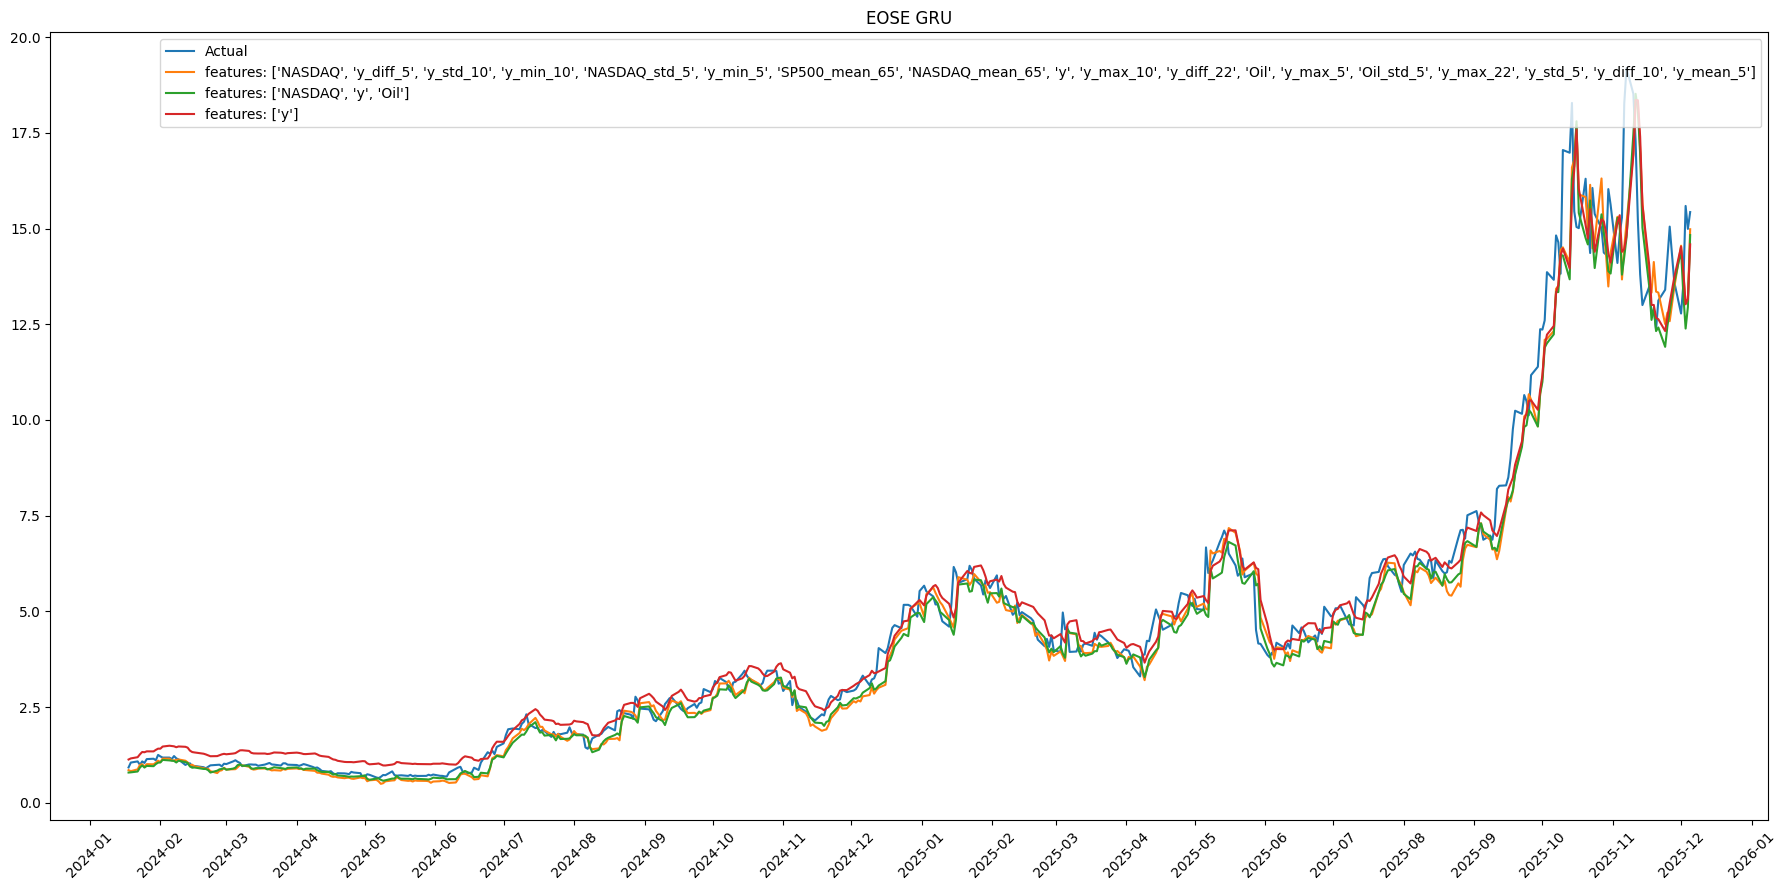

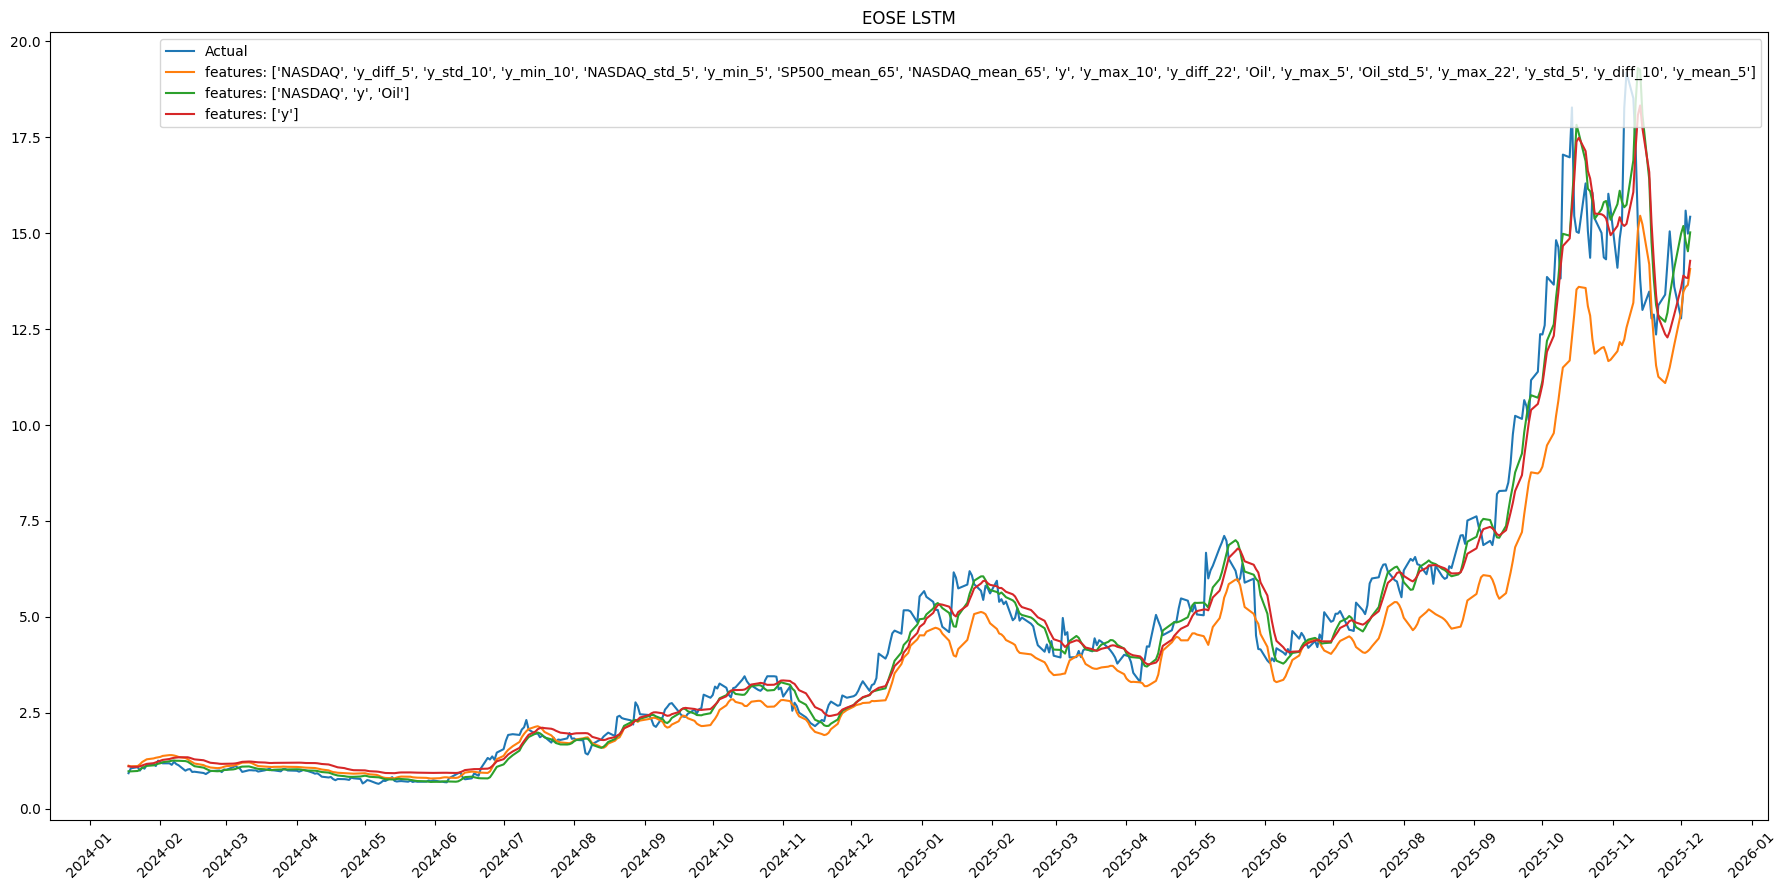

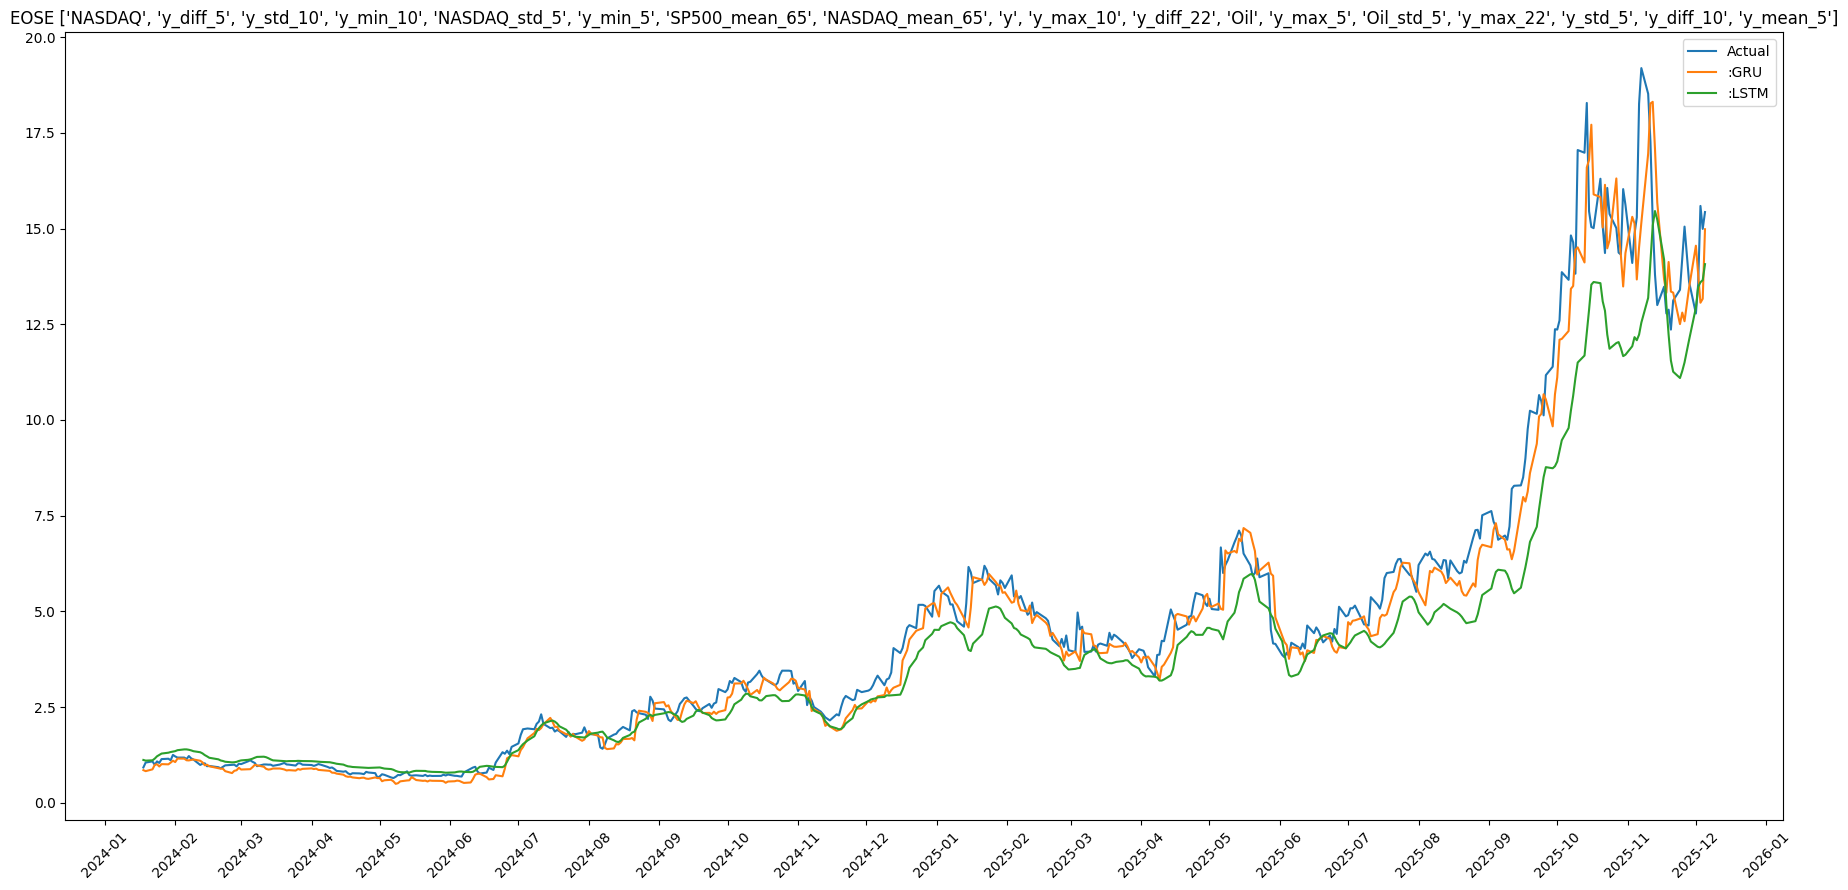

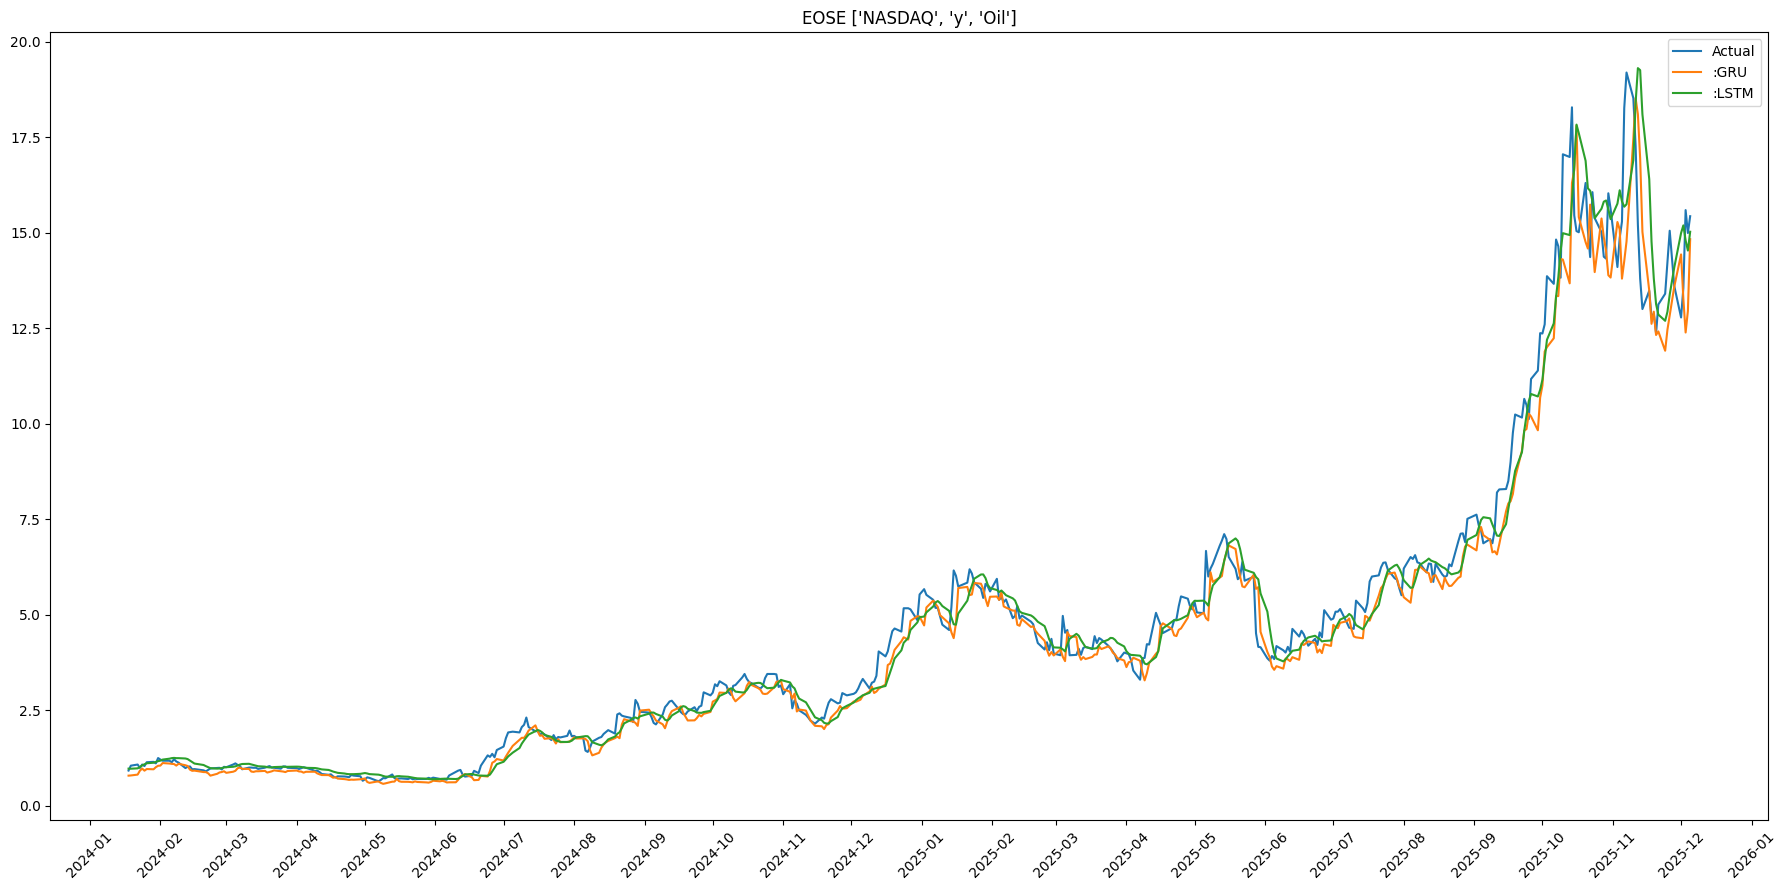

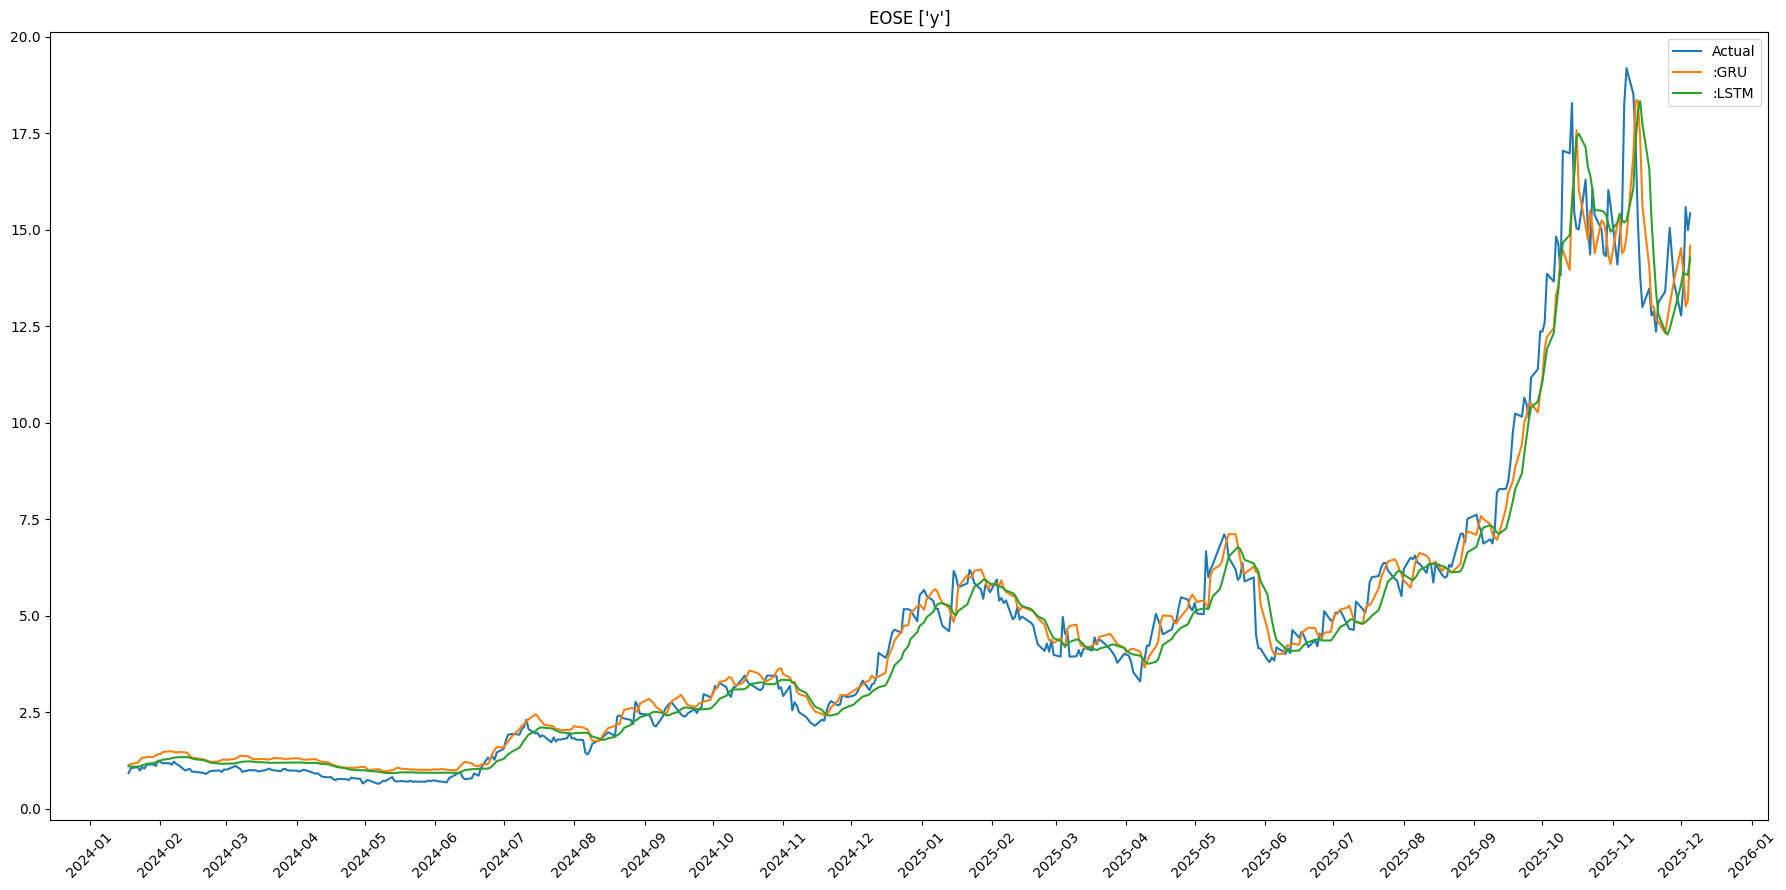

In [9]:
plot_results(results_df)

In [10]:
print(f"AND THE WINNER for {project_config['TKL']} IS ...")
results_df.sort_values(by='mae', ascending=True).iloc[0]

AND THE WINNER for EOSE IS ...


,2
model_name,GRU
X_cols,"[NASDAQ, y, Oil]"
prediction,"[[0.789259], [0.7940341], [0.8163173], [0.9200..."
mae,0.410203
r2,0.97001
model,"<Sequential name=sequential_2, built=True>"
X_cols_tuple,"(NASDAQ, y, Oil)"


In [11]:
winning_model = results_df.sort_values(by='mae', ascending=True).iloc[0].model
winning_model_name = results_df.sort_values(by='mae', ascending=True).iloc[0].model_name
model_path = f"{os.getenv('PROJECT_PATH')}{project_config['pickles_directory']}{project_config['TKL']}.model.{winning_model_name}.keras"
winning_model.save(model_path)